In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from scipy.sparse import hstack, vstack, csr_matrix
from sklearn import preprocessing

from keras_tqdm import TQDMNotebookCallback, TQDMCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Embedding, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.layers.normalization import BatchNormalization


from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

from multiprocessing import Pool

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

#font = {'family': 'Verdana', 'weight': 'normal'}
#rc('font', **font)
matplotlib.style.use('ggplot')

%matplotlib inline

pd.set_option('display.max_rows', 15)

In [3]:
#spacy.util.set_data_path('/home/data/spacy/en-1.1.0')
#spacy.util.set_data_path('/home/data/spacy/en_glove_cc_300_1m_vectors-1.0.0')
nlp = spacy.load('en')

# Загрузка данных

In [4]:
train_set = pd.read_table('/home/data/shad-yelp-sentiment-analysis/train.data', index_col=0)
test_set = pd.read_table('/home/data/shad-yelp-sentiment-analysis/test.data', index_col=0)

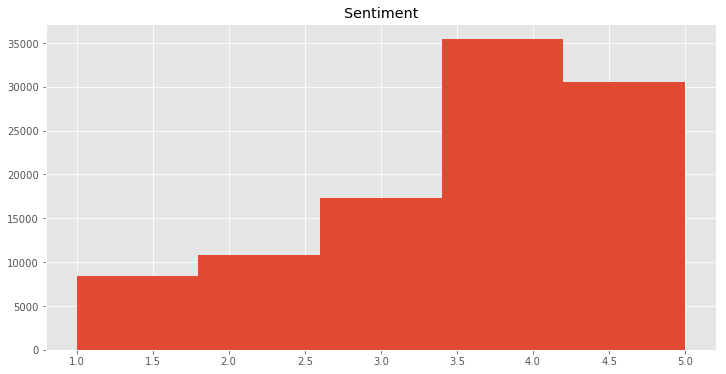

In [5]:
train_set.hist(column='Sentiment', bins=5, figsize=(12, 6))
plt.show()

In [6]:
Y_train = train_set['Sentiment']
Y_train_categorical = np_utils.to_categorical(Y_train)[:, 1:]

In [7]:
Y_train_counts = train_set['Sentiment'].value_counts()[[1, 2, 3, 4, 5]]
Y_train_counts

1     8457
2    10798
3    17340
4    35432
5    30517
Name: Sentiment, dtype: int64

In [8]:
Y_train_percents = Y_train_counts/Y_train.size
Y_train_percents = Y_train_percents.values
Y_train_percents

array([ 0.08247191,  0.10530114,  0.16909814,  0.34552972,  0.29759908])

# Data Preparation

## Tokenization

### Spacy.io

In [9]:
def remove_character_from_string(s, old_characters_list=['\n', '\t'], new_characters_list=None):
    if not new_characters_list:
        new_characters_list = [' ']*len(old_characters_list)
        
    for old_c, new_c in zip(old_characters_list, new_characters_list):
        s = s.replace(old_c, new_c)
        
    return s

def remove_extra_spaces(s):
    return ' '.join( s.split() )

In [10]:
money_regex = r'\$[0-9.,]+'

def money_regex_replace(s):
    return re.sub(money_regex, ' money_regex ', s)

In [11]:
dots_regex = r'\.[.]+'

def dots_replace(s):
    return re.sub(dots_regex, ' ... ', s)

In [12]:
def clear_string(s, to_lower=True):
    s = remove_character_from_string(s, 
                                     ['\\n', '\\"', '-', '"', "\\", ')', '(', '/'], 
                                     [' ', ' ', ' - ', ' ', '', ' ) ', ' ( ', ' / '])
    s = money_regex_replace(s)
    s = dots_replace(s)
    s = remove_extra_spaces(s)
    s = s.lower() if to_lower else s
    return s

In [13]:
def get_spacy_tokens_objects(s):
    s = clear_string(s, to_lower=False)
    return nlp(s)

if 1==0:
    train_tokenized_objects = train_set['Text'].apply(get_spacy_tokens_objects)
    test_tokenized_objects = test_set['Text'].apply(get_spacy_tokens_objects)

In [14]:
def text_from_spacy_tokens(tokens):
    tokens = [token.lower_ for token in tokens]
    #tokens = [token.lemma_ if not ((token.is_oov) or (token.lemma_ == '-PRON-')) else token.lower_ for token in tokens]
    return ' '.join(tokens)

if 1==0:
    train_tokenized = train_tokenized_objects.apply(text_from_spacy_tokens)
    test_tokenized = test_tokenized_objects.apply(text_from_spacy_tokens)

In [15]:
method = 'load'

if method == 'store':
    train_tokenized.to_csv('train_tokenized_lemma.csv', index='Id', header=['Sentiment'])
    test_tokenized.to_csv('test_tokenized_lemma.csv', index='Id', header=['Sentiment'])
    
if method == 'load':
    train_tokenized = pd.read_csv('train_tokenized_lemma.csv', index_col='Id', header=0)
    test_tokenized = pd.read_csv('test_tokenized_lemma.csv', index_col='Id', header=0)
    
    train_tokenized = train_tokenized['Sentiment']
    test_tokenized = test_tokenized['Sentiment']

In [16]:
def space_tokenizer(s):
    return s.split(' ')

# Features

### word2vec squence

In [17]:
def text_from_tokens_spacy(tokens):
    tokens = [token.text for token in tokens]
    return ' '.join(tokens)

In [18]:
w2v_parh = os.path.join(os.sep, os.path.abspath('/home/data/word2vec/english/GoogleNews-vectors-negative300.bin'))
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_parh, binary=True)
w2v.init_sims(replace=True)

In [19]:
def tokens_sequence_embedding(words):
    sequence = [w2v.syn0norm[w2v.vocab[word].index] for word in words.split(' ') if word in w2v.vocab]

    if not sequence:
        return np.zeros(300)

    return np.concatenate(sequence)

#### Множества(train, test, validation)

In [20]:
train_features = train_tokenized.values
test_features = test_tokenized.values

In [21]:
x_train, x_validation, y_train, y_validation = train_test_split(train_features, Y_train_categorical,
                                                                test_size=0.1, random_state=42)

x_test = test_features

# Models

### GRU without Embending layer

### batch_generator

In [22]:
batch_size, timesteps, data_dim = 64, 500, 300

def pad_or_truncate(a, n):
    if len(a)<n:
        a = np.lib.pad(a, (n-len(a), 0), mode='constant', constant_values=0)
    if len(a)>n:
        a = a[:n]
    return a.reshape((timesteps, data_dim))

def batch_to_sequence(texts):
    result = [tokens_sequence_embedding(text) for text in texts]
    result = np.array([pad_or_truncate(l, data_dim*timesteps) for l in result])
    return result

In [23]:
def batch_generator(X, Y, batch_size, shuffle=False):
    number_of_batches, counter, shuffle_index = X.shape[0]//batch_size, 0, np.arange(Y.shape[0])
    
    if shuffle:
        np.random.shuffle(shuffle_index)
    
    X, Y =  X[shuffle_index], Y[shuffle_index]
    
    while True:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch, Y_batch = X[index_batch], Y[index_batch]
        counter += 1
        yield batch_to_sequence(X_batch), Y_batch
        
        if counter == number_of_batches:
            if shuffle:
                np.random.shuffle(shuffle_index)
            counter=0

### model

In [24]:
histories = []

def get_nn_model(*, path_to_hdf5=False, input_dim=None):
    input_dim = x_train.shape[1] if not input_dim else input_dim
    
    # Create model
    model = Sequential()
    model.add(GRU(300, recurrent_dropout=0.2, dropout=0.2, input_shape=input_dim))
    model.add(Dense(5, kernel_initializer='he_normal', activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    print(model.summary())
    return model

filepath="GRU_weights_{epoch:02d}_{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=10, mode='max')
callbacks_list = [checkpoint, early_stopping, TQDMNotebookCallback()]

### Training

In [25]:
steps_per_epoch = 256#batch_size*(x_train_filtred.shape[0] // batch_size)
validation_steps = 256#batch_size*(x_validation_filtred.shape[0] // batch_size)
input_dim=(timesteps, data_dim)

y_train_categorical = y_train
y_validation_categorical = y_validation

model = get_nn_model(input_dim=input_dim)
history = model.fit_generator(generator=batch_generator(x_train, y_train_categorical, batch_size, shuffle=True),
                              steps_per_epoch=steps_per_epoch,
                              validation_data=batch_generator(x_validation, y_validation_categorical,
                                                              batch_size, shuffle=False),
                              validation_steps=validation_steps,
                              epochs=1000, verbose=2, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1505      
Total params: 542,405.0
Trainable params: 542,405
Non-trainable params: 0.0
_________________________________________________________________
None


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Epoch 1/1000
Epoch 00000: val_acc improved from -inf to 0.38635, saving model to GRU_weights_00_0.386.hdf5
103s - loss: 1.4313 - acc: 0.3589 - val_loss: 1.3715 - val_acc: 0.3864
Epoch 2/1000


The installed widget Javascript is the wrong version.


Epoch 00001: val_acc improved from 0.38635 to 0.50702, saving model to GRU_weights_01_0.507.hdf5
103s - loss: 1.2789 - acc: 0.4234 - val_loss: 1.1316 - val_acc: 0.5070
Epoch 3/1000


The installed widget Javascript is the wrong version.


Epoch 00002: val_acc improved from 0.50702 to 0.54199, saving model to GRU_weights_02_0.542.hdf5
104s - loss: 1.0857 - acc: 0.5181 - val_loss: 1.0127 - val_acc: 0.5420
Epoch 4/1000


The installed widget Javascript is the wrong version.


Epoch 00003: val_acc improved from 0.54199 to 0.56055, saving model to GRU_weights_03_0.561.hdf5
104s - loss: 1.0427 - acc: 0.5266 - val_loss: 0.9783 - val_acc: 0.5605
Epoch 5/1000


The installed widget Javascript is the wrong version.


Epoch 00004: val_acc did not improve
104s - loss: 1.0148 - acc: 0.5417 - val_loss: 0.9777 - val_acc: 0.5568
Epoch 6/1000


The installed widget Javascript is the wrong version.


Epoch 00005: val_acc improved from 0.56055 to 0.56641, saving model to GRU_weights_05_0.566.hdf5
104s - loss: 0.9861 - acc: 0.5549 - val_loss: 0.9515 - val_acc: 0.5664
Epoch 7/1000


The installed widget Javascript is the wrong version.


Epoch 00006: val_acc improved from 0.56641 to 0.58289, saving model to GRU_weights_06_0.583.hdf5
105s - loss: 0.9608 - acc: 0.5712 - val_loss: 0.9402 - val_acc: 0.5829
Epoch 8/1000


The installed widget Javascript is the wrong version.


Epoch 00007: val_acc did not improve
106s - loss: 0.9654 - acc: 0.5649 - val_loss: 0.9366 - val_acc: 0.5775
Epoch 9/1000


The installed widget Javascript is the wrong version.


Epoch 00008: val_acc improved from 0.58289 to 0.58423, saving model to GRU_weights_08_0.584.hdf5
105s - loss: 0.9495 - acc: 0.5746 - val_loss: 0.9253 - val_acc: 0.5842
Epoch 10/1000


The installed widget Javascript is the wrong version.


Epoch 00009: val_acc improved from 0.58423 to 0.58960, saving model to GRU_weights_09_0.590.hdf5
105s - loss: 0.9388 - acc: 0.5768 - val_loss: 0.9084 - val_acc: 0.5896
Epoch 11/1000


The installed widget Javascript is the wrong version.


Epoch 00010: val_acc improved from 0.58960 to 0.59418, saving model to GRU_weights_10_0.594.hdf5
105s - loss: 0.9295 - acc: 0.5845 - val_loss: 0.8989 - val_acc: 0.5942
Epoch 12/1000


The installed widget Javascript is the wrong version.


Epoch 00011: val_acc improved from 0.59418 to 0.59991, saving model to GRU_weights_11_0.600.hdf5
122s - loss: 0.9146 - acc: 0.5892 - val_loss: 0.8922 - val_acc: 0.5999
Epoch 13/1000


The installed widget Javascript is the wrong version.


Epoch 00012: val_acc did not improve
116s - loss: 0.9050 - acc: 0.5959 - val_loss: 0.8987 - val_acc: 0.5966
Epoch 14/1000


The installed widget Javascript is the wrong version.


Epoch 00013: val_acc improved from 0.59991 to 0.60034, saving model to GRU_weights_13_0.600.hdf5
105s - loss: 0.9104 - acc: 0.5892 - val_loss: 0.8806 - val_acc: 0.6003
Epoch 15/1000


The installed widget Javascript is the wrong version.


Epoch 00014: val_acc did not improve
106s - loss: 0.8997 - acc: 0.5975 - val_loss: 0.8859 - val_acc: 0.5979
Epoch 16/1000


The installed widget Javascript is the wrong version.


Epoch 00015: val_acc improved from 0.60034 to 0.60077, saving model to GRU_weights_15_0.601.hdf5
107s - loss: 0.8984 - acc: 0.5945 - val_loss: 0.8869 - val_acc: 0.6008
Epoch 17/1000


The installed widget Javascript is the wrong version.


Epoch 00016: val_acc improved from 0.60077 to 0.60144, saving model to GRU_weights_16_0.601.hdf5
106s - loss: 0.8879 - acc: 0.6031 - val_loss: 0.8720 - val_acc: 0.6014
Epoch 18/1000


The installed widget Javascript is the wrong version.


Epoch 00017: val_acc improved from 0.60144 to 0.60864, saving model to GRU_weights_17_0.609.hdf5
111s - loss: 0.8795 - acc: 0.6091 - val_loss: 0.8670 - val_acc: 0.6086
Epoch 19/1000


The installed widget Javascript is the wrong version.


Epoch 00018: val_acc improved from 0.60864 to 0.61200, saving model to GRU_weights_18_0.612.hdf5
107s - loss: 0.8618 - acc: 0.6204 - val_loss: 0.8703 - val_acc: 0.6120
Epoch 20/1000


The installed widget Javascript is the wrong version.


Epoch 00019: val_acc did not improve
107s - loss: 0.8728 - acc: 0.6127 - val_loss: 0.8623 - val_acc: 0.6112
Epoch 21/1000


The installed widget Javascript is the wrong version.


Epoch 00020: val_acc did not improve
107s - loss: 0.8588 - acc: 0.6210 - val_loss: 0.8650 - val_acc: 0.6098
Epoch 22/1000


The installed widget Javascript is the wrong version.


Epoch 00021: val_acc improved from 0.61200 to 0.61469, saving model to GRU_weights_21_0.615.hdf5
107s - loss: 0.8659 - acc: 0.6110 - val_loss: 0.8588 - val_acc: 0.6147
Epoch 23/1000


The installed widget Javascript is the wrong version.


Epoch 00022: val_acc improved from 0.61469 to 0.61774, saving model to GRU_weights_22_0.618.hdf5
104s - loss: 0.8557 - acc: 0.6168 - val_loss: 0.8622 - val_acc: 0.6177
Epoch 24/1000


The installed widget Javascript is the wrong version.


Epoch 00023: val_acc improved from 0.61774 to 0.62244, saving model to GRU_weights_23_0.622.hdf5
103s - loss: 0.8374 - acc: 0.6251 - val_loss: 0.8482 - val_acc: 0.6224
Epoch 25/1000


The installed widget Javascript is the wrong version.


Epoch 00024: val_acc did not improve
104s - loss: 0.8382 - acc: 0.6297 - val_loss: 0.8466 - val_acc: 0.6180
Epoch 26/1000


The installed widget Javascript is the wrong version.


Epoch 00025: val_acc did not improve
107s - loss: 0.8451 - acc: 0.6230 - val_loss: 0.8641 - val_acc: 0.6143
Epoch 27/1000


The installed widget Javascript is the wrong version.


Epoch 00026: val_acc improved from 0.62244 to 0.62830, saving model to GRU_weights_26_0.628.hdf5
107s - loss: 0.8304 - acc: 0.6300 - val_loss: 0.8408 - val_acc: 0.6283
Epoch 28/1000


The installed widget Javascript is the wrong version.


Epoch 00027: val_acc did not improve
107s - loss: 0.8393 - acc: 0.6248 - val_loss: 0.8353 - val_acc: 0.6248
Epoch 29/1000


The installed widget Javascript is the wrong version.


Epoch 00028: val_acc did not improve
107s - loss: 0.8111 - acc: 0.6411 - val_loss: 0.8456 - val_acc: 0.6207
Epoch 30/1000


The installed widget Javascript is the wrong version.


Epoch 00029: val_acc did not improve
107s - loss: 0.8065 - acc: 0.6394 - val_loss: 0.8495 - val_acc: 0.6227
Epoch 31/1000


The installed widget Javascript is the wrong version.


Epoch 00030: val_acc did not improve
107s - loss: 0.8068 - acc: 0.6423 - val_loss: 0.8605 - val_acc: 0.6157
Epoch 32/1000


The installed widget Javascript is the wrong version.


Epoch 00031: val_acc improved from 0.62830 to 0.62903, saving model to GRU_weights_31_0.629.hdf5
107s - loss: 0.8191 - acc: 0.6371 - val_loss: 0.8358 - val_acc: 0.6290
Epoch 33/1000


The installed widget Javascript is the wrong version.


Epoch 00032: val_acc did not improve
107s - loss: 0.8178 - acc: 0.6335 - val_loss: 0.8480 - val_acc: 0.6175
Epoch 34/1000


The installed widget Javascript is the wrong version.


Epoch 00033: val_acc did not improve
104s - loss: 0.8068 - acc: 0.6411 - val_loss: 0.8337 - val_acc: 0.6284
Epoch 35/1000


The installed widget Javascript is the wrong version.


Epoch 00034: val_acc improved from 0.62903 to 0.63000, saving model to GRU_weights_34_0.630.hdf5
104s - loss: 0.7942 - acc: 0.6415 - val_loss: 0.8349 - val_acc: 0.6300
Epoch 36/1000


The installed widget Javascript is the wrong version.


Epoch 00035: val_acc did not improve
104s - loss: 0.7887 - acc: 0.6550 - val_loss: 0.8328 - val_acc: 0.6296
Epoch 37/1000


The installed widget Javascript is the wrong version.


Epoch 00036: val_acc improved from 0.63000 to 0.63123, saving model to GRU_weights_36_0.631.hdf5
104s - loss: 0.7785 - acc: 0.6567 - val_loss: 0.8475 - val_acc: 0.6312
Epoch 38/1000


The installed widget Javascript is the wrong version.


Epoch 00037: val_acc improved from 0.63123 to 0.63452, saving model to GRU_weights_37_0.635.hdf5
104s - loss: 0.7886 - acc: 0.6481 - val_loss: 0.8212 - val_acc: 0.6345
Epoch 39/1000


The installed widget Javascript is the wrong version.


Epoch 00038: val_acc did not improve
103s - loss: 0.7867 - acc: 0.6537 - val_loss: 0.8335 - val_acc: 0.6321
Epoch 40/1000


The installed widget Javascript is the wrong version.


Epoch 00039: val_acc did not improve
104s - loss: 0.7610 - acc: 0.6593 - val_loss: 0.8318 - val_acc: 0.6276
Epoch 41/1000


The installed widget Javascript is the wrong version.


Epoch 00040: val_acc did not improve
104s - loss: 0.7578 - acc: 0.6619 - val_loss: 0.8251 - val_acc: 0.6324
Epoch 42/1000


The installed widget Javascript is the wrong version.


Epoch 00041: val_acc improved from 0.63452 to 0.64026, saving model to GRU_weights_41_0.640.hdf5
104s - loss: 0.7672 - acc: 0.6614 - val_loss: 0.8320 - val_acc: 0.6403
Epoch 43/1000


The installed widget Javascript is the wrong version.


Epoch 00042: val_acc did not improve
104s - loss: 0.7701 - acc: 0.6611 - val_loss: 0.8268 - val_acc: 0.6325
Epoch 44/1000


The installed widget Javascript is the wrong version.


Epoch 00043: val_acc did not improve
104s - loss: 0.7676 - acc: 0.6592 - val_loss: 0.8228 - val_acc: 0.6349
Epoch 45/1000


The installed widget Javascript is the wrong version.


Epoch 00044: val_acc did not improve
105s - loss: 0.7611 - acc: 0.6628 - val_loss: 0.8208 - val_acc: 0.6385
Epoch 46/1000


The installed widget Javascript is the wrong version.


Epoch 00045: val_acc did not improve
106s - loss: 0.7428 - acc: 0.6764 - val_loss: 0.8484 - val_acc: 0.6307
Epoch 47/1000


The installed widget Javascript is the wrong version.


Epoch 00046: val_acc improved from 0.64026 to 0.64124, saving model to GRU_weights_46_0.641.hdf5
107s - loss: 0.7449 - acc: 0.6724 - val_loss: 0.8308 - val_acc: 0.6412
Epoch 48/1000


The installed widget Javascript is the wrong version.


Epoch 00047: val_acc did not improve
107s - loss: 0.7401 - acc: 0.6728 - val_loss: 0.8360 - val_acc: 0.6329
Epoch 49/1000


The installed widget Javascript is the wrong version.


Epoch 00048: val_acc did not improve
107s - loss: 0.7372 - acc: 0.6777 - val_loss: 0.8247 - val_acc: 0.6307
Epoch 50/1000


The installed widget Javascript is the wrong version.


Epoch 00049: val_acc did not improve
107s - loss: 0.7449 - acc: 0.6695 - val_loss: 0.8251 - val_acc: 0.6336
Epoch 51/1000


The installed widget Javascript is the wrong version.


Epoch 00050: val_acc did not improve
106s - loss: 0.7375 - acc: 0.6746 - val_loss: 0.8234 - val_acc: 0.6389
Epoch 52/1000


The installed widget Javascript is the wrong version.


Epoch 00051: val_acc did not improve
107s - loss: 0.7208 - acc: 0.6812 - val_loss: 0.8328 - val_acc: 0.6325
Epoch 53/1000


The installed widget Javascript is the wrong version.


Epoch 00052: val_acc did not improve
107s - loss: 0.7186 - acc: 0.6802 - val_loss: 0.8224 - val_acc: 0.6380
Epoch 54/1000


The installed widget Javascript is the wrong version.


Epoch 00053: val_acc did not improve
105s - loss: 0.7218 - acc: 0.6821 - val_loss: 0.8320 - val_acc: 0.6362
Epoch 55/1000


The installed widget Javascript is the wrong version.


Epoch 00054: val_acc improved from 0.64124 to 0.64343, saving model to GRU_weights_54_0.643.hdf5
104s - loss: 0.7276 - acc: 0.6794 - val_loss: 0.8185 - val_acc: 0.6434
Epoch 56/1000


The installed widget Javascript is the wrong version.


Epoch 00055: val_acc did not improve
104s - loss: 0.7329 - acc: 0.6753 - val_loss: 0.8209 - val_acc: 0.6387
Epoch 57/1000


The installed widget Javascript is the wrong version.


Epoch 00056: val_acc did not improve
104s - loss: 0.7056 - acc: 0.6894 - val_loss: 0.8327 - val_acc: 0.6408
Epoch 58/1000


The installed widget Javascript is the wrong version.


Epoch 00057: val_acc did not improve
104s - loss: 0.7029 - acc: 0.6891 - val_loss: 0.8276 - val_acc: 0.6332
Epoch 59/1000


The installed widget Javascript is the wrong version.


Epoch 00058: val_acc did not improve
104s - loss: 0.7081 - acc: 0.6862 - val_loss: 0.8323 - val_acc: 0.6381
Epoch 60/1000


The installed widget Javascript is the wrong version.


Epoch 00059: val_acc improved from 0.64343 to 0.64514, saving model to GRU_weights_59_0.645.hdf5
105s - loss: 0.7078 - acc: 0.6873 - val_loss: 0.8284 - val_acc: 0.6451
Epoch 61/1000


The installed widget Javascript is the wrong version.


Epoch 00060: val_acc did not improve
105s - loss: 0.6968 - acc: 0.6959 - val_loss: 0.8227 - val_acc: 0.6401
Epoch 62/1000


The installed widget Javascript is the wrong version.


Epoch 00061: val_acc did not improve
105s - loss: 0.7196 - acc: 0.6868 - val_loss: 0.8354 - val_acc: 0.6379
Epoch 63/1000


The installed widget Javascript is the wrong version.


Epoch 00062: val_acc did not improve
105s - loss: 0.6723 - acc: 0.7073 - val_loss: 0.8325 - val_acc: 0.6403
Epoch 64/1000


The installed widget Javascript is the wrong version.


Epoch 00063: val_acc did not improve
105s - loss: 0.6805 - acc: 0.6993 - val_loss: 0.8451 - val_acc: 0.6387
Epoch 65/1000


The installed widget Javascript is the wrong version.


Epoch 00064: val_acc did not improve
105s - loss: 0.6876 - acc: 0.6968 - val_loss: 0.8468 - val_acc: 0.6372
Epoch 66/1000


The installed widget Javascript is the wrong version.


Epoch 00065: val_acc did not improve
105s - loss: 0.6947 - acc: 0.6927 - val_loss: 0.8265 - val_acc: 0.6375
Epoch 67/1000


The installed widget Javascript is the wrong version.


Epoch 00066: val_acc did not improve
104s - loss: 0.6888 - acc: 0.7001 - val_loss: 0.8414 - val_acc: 0.6404
Epoch 68/1000


The installed widget Javascript is the wrong version.


Epoch 00067: val_acc did not improve
105s - loss: 0.6869 - acc: 0.7021 - val_loss: 0.8405 - val_acc: 0.6422
Epoch 69/1000


The installed widget Javascript is the wrong version.


Epoch 00068: val_acc did not improve
104s - loss: 0.6690 - acc: 0.7054 - val_loss: 0.8302 - val_acc: 0.6415
Epoch 70/1000


The installed widget Javascript is the wrong version.


Epoch 00069: val_acc did not improve
104s - loss: 0.6657 - acc: 0.7081 - val_loss: 0.8389 - val_acc: 0.6424
Epoch 71/1000


The installed widget Javascript is the wrong version.


Epoch 00070: val_acc did not improve
105s - loss: 0.6644 - acc: 0.7086 - val_loss: 0.8333 - val_acc: 0.6429



### GRU with Dense layers

### model

In [63]:
histories = []

def get_nn_model(*, path_to_hdf5=False, input_dim=None):
    input_dim = x_train.shape[1] if not input_dim else input_dim
    
    # Create model
    model = Sequential()
    model.add(GRU(300, recurrent_dropout=0.2, dropout=0.2, input_shape=input_dim))
    model.add(Dense(50, kernel_initializer='he_normal', activation='sigmoid'))
    model.add(Dense(5, kernel_initializer='he_normal', activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    print(model.summary())
    return model

filepath="GRU_Dense_weights_{epoch:02d}_{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=10, mode='max')
callbacks_list = [checkpoint, early_stopping, TQDMNotebookCallback()]

### Training

In [64]:
steps_per_epoch = 1024#batch_size*(x_train_filtred.shape[0] // batch_size)
validation_steps = 1024#batch_size*(x_validation_filtred.shape[0] // batch_size)
input_dim=(timesteps, data_dim)

y_train_categorical = y_train
y_validation_categorical = y_validation

model = get_nn_model(input_dim=input_dim)
history = model.fit_generator(generator=batch_generator(x_train, y_train_categorical, batch_size, shuffle=True),
                              steps_per_epoch=steps_per_epoch,
                              validation_data=batch_generator(x_validation, y_validation_categorical,
                                                              batch_size, shuffle=False),
                              validation_steps=validation_steps,
                              epochs=1000, verbose=2, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 255       
Total params: 556,205.0
Trainable params: 556,205
Non-trainable params: 0.0
_________________________________________________________________
None


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Epoch 1/1000
Epoch 00000: val_acc improved from -inf to 0.54208, saving model to GRU_Dense_weights_00_0.542.hdf5
824s - loss: 1.2240 - acc: 0.4466 - val_loss: 1.0153 - val_acc: 0.5421
Epoch 2/1000


The installed widget Javascript is the wrong version.


Epoch 00001: val_acc improved from 0.54208 to 0.56168, saving model to GRU_Dense_weights_01_0.562.hdf5
828s - loss: 1.0175 - acc: 0.5419 - val_loss: 0.9594 - val_acc: 0.5617
Epoch 3/1000


The installed widget Javascript is the wrong version.


Epoch 00002: val_acc improved from 0.56168 to 0.57858, saving model to GRU_Dense_weights_02_0.579.hdf5
831s - loss: 0.9613 - acc: 0.5689 - val_loss: 0.9217 - val_acc: 0.5786
Epoch 4/1000


The installed widget Javascript is the wrong version.


Epoch 00003: val_acc improved from 0.57858 to 0.59253, saving model to GRU_Dense_weights_03_0.593.hdf5
830s - loss: 0.9274 - acc: 0.5819 - val_loss: 0.9000 - val_acc: 0.5925
Epoch 5/1000


The installed widget Javascript is the wrong version.


Epoch 00004: val_acc improved from 0.59253 to 0.59671, saving model to GRU_Dense_weights_04_0.597.hdf5
840s - loss: 0.9012 - acc: 0.5970 - val_loss: 0.8901 - val_acc: 0.5967
Epoch 6/1000


The installed widget Javascript is the wrong version.


Epoch 00005: val_acc improved from 0.59671 to 0.59708, saving model to GRU_Dense_weights_05_0.597.hdf5
832s - loss: 0.8849 - acc: 0.6057 - val_loss: 0.9008 - val_acc: 0.5971
Epoch 7/1000


The installed widget Javascript is the wrong version.


Epoch 00006: val_acc improved from 0.59708 to 0.61711, saving model to GRU_Dense_weights_06_0.617.hdf5
831s - loss: 0.8619 - acc: 0.6160 - val_loss: 0.8555 - val_acc: 0.6171
Epoch 8/1000


The installed widget Javascript is the wrong version.


Epoch 00007: val_acc improved from 0.61711 to 0.62036, saving model to GRU_Dense_weights_07_0.620.hdf5
832s - loss: 0.8414 - acc: 0.6252 - val_loss: 0.8659 - val_acc: 0.6204
Epoch 9/1000


The installed widget Javascript is the wrong version.


Epoch 00008: val_acc improved from 0.62036 to 0.62379, saving model to GRU_Dense_weights_08_0.624.hdf5
832s - loss: 0.8266 - acc: 0.6327 - val_loss: 0.8461 - val_acc: 0.6238
Epoch 10/1000


The installed widget Javascript is the wrong version.


Epoch 00009: val_acc improved from 0.62379 to 0.63106, saving model to GRU_Dense_weights_09_0.631.hdf5
831s - loss: 0.8133 - acc: 0.6402 - val_loss: 0.8357 - val_acc: 0.6311
Epoch 11/1000


The installed widget Javascript is the wrong version.


Epoch 00010: val_acc did not improve
832s - loss: 0.7934 - acc: 0.6476 - val_loss: 0.8479 - val_acc: 0.6268
Epoch 12/1000


The installed widget Javascript is the wrong version.


Epoch 00011: val_acc improved from 0.63106 to 0.63390, saving model to GRU_Dense_weights_11_0.634.hdf5
832s - loss: 0.7768 - acc: 0.6582 - val_loss: 0.8299 - val_acc: 0.6339
Epoch 13/1000


The installed widget Javascript is the wrong version.


Epoch 00012: val_acc did not improve
829s - loss: 0.7662 - acc: 0.6640 - val_loss: 0.8378 - val_acc: 0.6302
Epoch 14/1000


The installed widget Javascript is the wrong version.


Epoch 00013: val_acc did not improve
827s - loss: 0.7561 - acc: 0.6680 - val_loss: 0.8331 - val_acc: 0.6320
Epoch 15/1000


The installed widget Javascript is the wrong version.


Epoch 00014: val_acc improved from 0.63390 to 0.63405, saving model to GRU_Dense_weights_14_0.634.hdf5
864s - loss: 0.7291 - acc: 0.6793 - val_loss: 0.8315 - val_acc: 0.6340
Epoch 16/1000


The installed widget Javascript is the wrong version.


Epoch 00015: val_acc did not improve
903s - loss: 0.7217 - acc: 0.6823 - val_loss: 0.8418 - val_acc: 0.6340
Epoch 17/1000


The installed widget Javascript is the wrong version.


Epoch 00016: val_acc improved from 0.63405 to 0.63535, saving model to GRU_Dense_weights_16_0.635.hdf5
843s - loss: 0.7165 - acc: 0.6856 - val_loss: 0.8346 - val_acc: 0.6353
Epoch 18/1000


The installed widget Javascript is the wrong version.


Epoch 00017: val_acc improved from 0.63535 to 0.64047, saving model to GRU_Dense_weights_17_0.640.hdf5
832s - loss: 0.6918 - acc: 0.6982 - val_loss: 0.8324 - val_acc: 0.6405
Epoch 19/1000


The installed widget Javascript is the wrong version.


Epoch 00018: val_acc did not improve
832s - loss: 0.6831 - acc: 0.7020 - val_loss: 0.8366 - val_acc: 0.6360
Epoch 20/1000


The installed widget Javascript is the wrong version.


Epoch 00019: val_acc did not improve
834s - loss: 0.6718 - acc: 0.7059 - val_loss: 0.8619 - val_acc: 0.6315
Epoch 21/1000


The installed widget Javascript is the wrong version.


Epoch 00020: val_acc did not improve
835s - loss: 0.6611 - acc: 0.7142 - val_loss: 0.8495 - val_acc: 0.6359
Epoch 22/1000


The installed widget Javascript is the wrong version.


Epoch 00021: val_acc did not improve
837s - loss: 0.6447 - acc: 0.7222 - val_loss: 0.8685 - val_acc: 0.6259
Epoch 23/1000


The installed widget Javascript is the wrong version.


Epoch 00022: val_acc did not improve
830s - loss: 0.6391 - acc: 0.7212 - val_loss: 0.8597 - val_acc: 0.6374
Epoch 24/1000


The installed widget Javascript is the wrong version.


Epoch 00023: val_acc improved from 0.64047 to 0.64232, saving model to GRU_Dense_weights_23_0.642.hdf5
830s - loss: 0.6346 - acc: 0.7249 - val_loss: 0.8634 - val_acc: 0.6423
Epoch 25/1000


The installed widget Javascript is the wrong version.


Epoch 00024: val_acc did not improve
1227s - loss: 0.6160 - acc: 0.7329 - val_loss: 0.8687 - val_acc: 0.6343
Epoch 26/1000


The installed widget Javascript is the wrong version.


KeyboardInterrupt: 

### LSTM without Embending layer

### model

In [58]:
histories = []

def get_nn_model(*, path_to_hdf5=False, input_dim=None):
    input_dim = x_train.shape[1] if not input_dim else input_dim
    
    # Create model
    model = Sequential()
    model.add(LSTM(300, recurrent_dropout=0.2, dropout=0.2, batch_input_shape=input_dim))
    model.add(Dense(5, kernel_initializer='he_normal', activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    print(model.summary())
    return model

filepath="LSTM_weights_{epoch:02d}_{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=10, mode='max')
callbacks_list = [checkpoint, early_stopping, TQDMNotebookCallback()]

### Training

In [59]:
steps_per_epoch = 256#batch_size*(x_train_filtred.shape[0] // batch_size)
validation_steps = 256#batch_size*(x_validation_filtred.shape[0] // batch_size)
input_dim=(batch_size, timesteps, data_dim)

y_train_categorical = y_train
y_validation_categorical = y_validation

In [ ]:
model = get_nn_model(input_dim=input_dim)
history = model.fit_generator(generator=batch_generator(x_train, y_train_categorical, batch_size, shuffle=True),
                              steps_per_epoch=steps_per_epoch,
                              validation_data=batch_generator(x_validation, y_validation_categorical,
                                                              batch_size, shuffle=False),
                              validation_steps=validation_steps,
                              epochs=1000, verbose=2, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (64, 300)                 721200    
_________________________________________________________________
dense_7 (Dense)              (64, 5)                   1505      
Total params: 722,705.0
Trainable params: 722,705
Non-trainable params: 0.0
_________________________________________________________________
None


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Epoch 1/1000
Epoch 00000: val_acc improved from -inf to 0.39417, saving model to GRU_weights_00_0.394.hdf5
132s - loss: 1.4324 - acc: 0.3561 - val_loss: 1.3082 - val_acc: 0.3942
Epoch 2/1000


The installed widget Javascript is the wrong version.


Epoch 00001: val_acc improved from 0.39417 to 0.43250, saving model to GRU_weights_01_0.432.hdf5
133s - loss: 1.3662 - acc: 0.3872 - val_loss: 1.2504 - val_acc: 0.4325
Epoch 3/1000


The installed widget Javascript is the wrong version.


Epoch 00002: val_acc did not improve
133s - loss: 1.3146 - acc: 0.4064 - val_loss: 1.2717 - val_acc: 0.4313
Epoch 4/1000


The installed widget Javascript is the wrong version.


Epoch 00003: val_acc did not improve
133s - loss: 1.3290 - acc: 0.4036 - val_loss: 1.3269 - val_acc: 0.3870
Epoch 5/1000


The installed widget Javascript is the wrong version.


Epoch 00004: val_acc improved from 0.43250 to 0.43750, saving model to GRU_weights_04_0.438.hdf5
133s - loss: 1.3075 - acc: 0.4102 - val_loss: 1.2225 - val_acc: 0.4375
Epoch 6/1000


The installed widget Javascript is the wrong version.


Epoch 00005: val_acc improved from 0.43750 to 0.43817, saving model to GRU_weights_05_0.438.hdf5
133s - loss: 1.2572 - acc: 0.4299 - val_loss: 1.2166 - val_acc: 0.4382
Epoch 7/1000


The installed widget Javascript is the wrong version.


Epoch 00006: val_acc improved from 0.43817 to 0.45215, saving model to GRU_weights_06_0.452.hdf5
133s - loss: 1.2343 - acc: 0.4437 - val_loss: 1.2121 - val_acc: 0.4521
Epoch 8/1000


The installed widget Javascript is the wrong version.


Epoch 00007: val_acc improved from 0.45215 to 0.48352, saving model to GRU_weights_07_0.484.hdf5
133s - loss: 1.2069 - acc: 0.4613 - val_loss: 1.1333 - val_acc: 0.4835
Epoch 9/1000


The installed widget Javascript is the wrong version.


Epoch 00008: val_acc improved from 0.48352 to 0.50916, saving model to GRU_weights_08_0.509.hdf5
133s - loss: 1.2116 - acc: 0.4581 - val_loss: 1.1034 - val_acc: 0.5092
Epoch 10/1000


The installed widget Javascript is the wrong version.


Epoch 00009: val_acc improved from 0.50916 to 0.52148, saving model to GRU_weights_09_0.521.hdf5
133s - loss: 1.1403 - acc: 0.4863 - val_loss: 1.0698 - val_acc: 0.5215
Epoch 11/1000


The installed widget Javascript is the wrong version.


Epoch 00010: val_acc improved from 0.52148 to 0.52850, saving model to GRU_weights_10_0.529.hdf5
133s - loss: 1.0895 - acc: 0.5121 - val_loss: 1.0488 - val_acc: 0.5285
Epoch 12/1000


The installed widget Javascript is the wrong version.


Epoch 00011: val_acc improved from 0.52850 to 0.54034, saving model to GRU_weights_11_0.540.hdf5
133s - loss: 1.0656 - acc: 0.5199 - val_loss: 1.0210 - val_acc: 0.5403
Epoch 13/1000


The installed widget Javascript is the wrong version.


Epoch 00012: val_acc did not improve
133s - loss: 1.0478 - acc: 0.5320 - val_loss: 1.0247 - val_acc: 0.5394
Epoch 14/1000


The installed widget Javascript is the wrong version.


Epoch 00013: val_acc improved from 0.54034 to 0.55212, saving model to GRU_weights_13_0.552.hdf5
133s - loss: 1.0298 - acc: 0.5432 - val_loss: 1.0053 - val_acc: 0.5521
Epoch 15/1000


The installed widget Javascript is the wrong version.


Epoch 00014: val_acc did not improve
133s - loss: 1.0308 - acc: 0.5350 - val_loss: 1.0153 - val_acc: 0.5472
Epoch 16/1000


The installed widget Javascript is the wrong version.


Epoch 00015: val_acc improved from 0.55212 to 0.55682, saving model to GRU_weights_15_0.557.hdf5
133s - loss: 1.0167 - acc: 0.5423 - val_loss: 0.9906 - val_acc: 0.5568
Epoch 17/1000


The installed widget Javascript is the wrong version.


Epoch 00016: val_acc improved from 0.55682 to 0.56659, saving model to GRU_weights_16_0.567.hdf5
133s - loss: 1.0164 - acc: 0.5432 - val_loss: 0.9673 - val_acc: 0.5666
Epoch 18/1000


The installed widget Javascript is the wrong version.


Epoch 00017: val_acc did not improve
133s - loss: 0.9885 - acc: 0.5536 - val_loss: 0.9795 - val_acc: 0.5540
Epoch 19/1000


The installed widget Javascript is the wrong version.


Epoch 00018: val_acc improved from 0.56659 to 0.57465, saving model to GRU_weights_18_0.575.hdf5
133s - loss: 0.9940 - acc: 0.5532 - val_loss: 0.9506 - val_acc: 0.5746
Epoch 20/1000


The installed widget Javascript is the wrong version.


Epoch 00019: val_acc did not improve
133s - loss: 0.9862 - acc: 0.5557 - val_loss: 0.9603 - val_acc: 0.5716
Epoch 21/1000


The installed widget Javascript is the wrong version.


Epoch 00021: val_acc did not improve
133s - loss: 0.9707 - acc: 0.5648 - val_loss: 0.9438 - val_acc: 0.5742
Epoch 23/1000


The installed widget Javascript is the wrong version.


Epoch 00022: val_acc improved from 0.57922 to 0.57941, saving model to GRU_weights_22_0.579.hdf5
133s - loss: 0.9580 - acc: 0.5696 - val_loss: 0.9342 - val_acc: 0.5794
Epoch 24/1000


The installed widget Javascript is the wrong version.


Epoch 00023: val_acc did not improve
133s - loss: 0.9557 - acc: 0.5683 - val_loss: 0.9394 - val_acc: 0.5771
Epoch 25/1000


The installed widget Javascript is the wrong version.


Epoch 00024: val_acc improved from 0.57941 to 0.58301, saving model to GRU_weights_24_0.583.hdf5
133s - loss: 0.9515 - acc: 0.5732 - val_loss: 0.9316 - val_acc: 0.5830
Epoch 26/1000


The installed widget Javascript is the wrong version.


Epoch 00025: val_acc did not improve
133s - loss: 0.9356 - acc: 0.5814 - val_loss: 0.9244 - val_acc: 0.5783
Epoch 27/1000


The installed widget Javascript is the wrong version.


Epoch 00026: val_acc improved from 0.58301 to 0.59003, saving model to GRU_weights_26_0.590.hdf5
133s - loss: 0.9472 - acc: 0.5768 - val_loss: 0.9215 - val_acc: 0.5900
Epoch 28/1000


The installed widget Javascript is the wrong version.


Epoch 00027: val_acc did not improve
133s - loss: 0.9400 - acc: 0.5804 - val_loss: 0.9222 - val_acc: 0.5833
Epoch 29/1000


The installed widget Javascript is the wrong version.


Epoch 00028: val_acc did not improve
133s - loss: 0.9243 - acc: 0.5839 - val_loss: 0.9153 - val_acc: 0.5895
Epoch 30/1000


The installed widget Javascript is the wrong version.


Epoch 00029: val_acc improved from 0.59003 to 0.59070, saving model to GRU_weights_29_0.591.hdf5
133s - loss: 0.9299 - acc: 0.5848 - val_loss: 0.9104 - val_acc: 0.5907
Epoch 31/1000


The installed widget Javascript is the wrong version.


Epoch 00030: val_acc did not improve
133s - loss: 0.9130 - acc: 0.5919 - val_loss: 0.9140 - val_acc: 0.5848
Epoch 32/1000


The installed widget Javascript is the wrong version.


Epoch 00032: val_acc did not improve
133s - loss: 0.9138 - acc: 0.5905 - val_loss: 0.9085 - val_acc: 0.5867
Epoch 34/1000


The installed widget Javascript is the wrong version.


Epoch 00033: val_acc improved from 0.59277 to 0.60364, saving model to GRU_weights_33_0.604.hdf5
133s - loss: 0.9163 - acc: 0.5872 - val_loss: 0.8948 - val_acc: 0.6036
Epoch 35/1000


The installed widget Javascript is the wrong version.


Epoch 00034: val_acc did not improve
133s - loss: 0.8992 - acc: 0.5990 - val_loss: 0.8981 - val_acc: 0.6002
Epoch 36/1000


The installed widget Javascript is the wrong version.


Epoch 00035: val_acc did not improve
133s - loss: 0.8926 - acc: 0.6027 - val_loss: 0.8919 - val_acc: 0.5964
Epoch 37/1000


The installed widget Javascript is the wrong version.


Epoch 00036: val_acc did not improve
133s - loss: 0.8980 - acc: 0.5992 - val_loss: 0.8912 - val_acc: 0.6000
Epoch 38/1000


The installed widget Javascript is the wrong version.


Epoch 00037: val_acc did not improve
133s - loss: 0.8946 - acc: 0.6015 - val_loss: 0.8865 - val_acc: 0.5964
Epoch 39/1000


The installed widget Javascript is the wrong version.


Epoch 00038: val_acc improved from 0.60364 to 0.60498, saving model to GRU_weights_38_0.605.hdf5
151s - loss: 0.8972 - acc: 0.5985 - val_loss: 0.8860 - val_acc: 0.6050
Epoch 40/1000


The installed widget Javascript is the wrong version.


Epoch 00039: val_acc improved from 0.60498 to 0.61493, saving model to GRU_weights_39_0.615.hdf5
165s - loss: 0.8799 - acc: 0.6109 - val_loss: 0.8756 - val_acc: 0.6149
Epoch 41/1000


The installed widget Javascript is the wrong version.


Epoch 00040: val_acc did not improve
133s - loss: 0.8709 - acc: 0.6122 - val_loss: 0.8786 - val_acc: 0.6047
Epoch 42/1000


The installed widget Javascript is the wrong version.


Epoch 00041: val_acc did not improve
133s - loss: 0.8776 - acc: 0.6099 - val_loss: 0.8772 - val_acc: 0.6021
Epoch 43/1000


The installed widget Javascript is the wrong version.


Epoch 00042: val_acc did not improve
134s - loss: 0.8723 - acc: 0.6104 - val_loss: 0.8677 - val_acc: 0.6094
Epoch 44/1000


The installed widget Javascript is the wrong version.


Epoch 00043: val_acc did not improve
135s - loss: 0.8730 - acc: 0.6076 - val_loss: 0.8724 - val_acc: 0.6082
Epoch 45/1000


The installed widget Javascript is the wrong version.


Epoch 00044: val_acc did not improve
179s - loss: 0.8652 - acc: 0.6167 - val_loss: 0.8710 - val_acc: 0.6126
Epoch 46/1000


The installed widget Javascript is the wrong version.


Epoch 00045: val_acc did not improve
133s - loss: 0.8474 - acc: 0.6255 - val_loss: 0.8634 - val_acc: 0.6103
Epoch 47/1000


The installed widget Javascript is the wrong version.


Epoch 00046: val_acc improved from 0.61493 to 0.61713, saving model to GRU_weights_46_0.617.hdf5
133s - loss: 0.8456 - acc: 0.6244 - val_loss: 0.8679 - val_acc: 0.6171
Epoch 48/1000


The installed widget Javascript is the wrong version.


Epoch 00047: val_acc did not improve
133s - loss: 0.8437 - acc: 0.6229 - val_loss: 0.8694 - val_acc: 0.6093
Epoch 49/1000


The installed widget Javascript is the wrong version.


Epoch 00048: val_acc did not improve
134s - loss: 0.8519 - acc: 0.6148 - val_loss: 0.8624 - val_acc: 0.6122
Epoch 50/1000


The installed widget Javascript is the wrong version.


Epoch 00049: val_acc did not improve
133s - loss: 0.8521 - acc: 0.6227 - val_loss: 0.8593 - val_acc: 0.6161
Epoch 51/1000


The installed widget Javascript is the wrong version.


Epoch 00050: val_acc improved from 0.61713 to 0.61792, saving model to GRU_weights_50_0.618.hdf5
133s - loss: 0.8346 - acc: 0.6316 - val_loss: 0.8502 - val_acc: 0.6179
Epoch 52/1000


The installed widget Javascript is the wrong version.


Epoch 00052: val_acc improved from 0.62012 to 0.62097, saving model to GRU_weights_52_0.621.hdf5
133s - loss: 0.8183 - acc: 0.6364 - val_loss: 0.8530 - val_acc: 0.6210
Epoch 54/1000


The installed widget Javascript is the wrong version.


Epoch 00053: val_acc did not improve
173s - loss: 0.8249 - acc: 0.6345 - val_loss: 0.8535 - val_acc: 0.6185
Epoch 55/1000


The installed widget Javascript is the wrong version.


Epoch 00054: val_acc improved from 0.62097 to 0.62354, saving model to GRU_weights_54_0.624.hdf5
191s - loss: 0.8232 - acc: 0.6378 - val_loss: 0.8464 - val_acc: 0.6235
Epoch 56/1000


The installed widget Javascript is the wrong version.


Epoch 00055: val_acc did not improve
166s - loss: 0.8251 - acc: 0.6299 - val_loss: 0.8438 - val_acc: 0.6209
Epoch 57/1000


The installed widget Javascript is the wrong version.


Epoch 00056: val_acc did not improve
132s - loss: 0.8096 - acc: 0.6398 - val_loss: 0.8478 - val_acc: 0.6203
Epoch 58/1000


The installed widget Javascript is the wrong version.


Epoch 00057: val_acc improved from 0.62354 to 0.62646, saving model to GRU_weights_57_0.626.hdf5
132s - loss: 0.8039 - acc: 0.6407 - val_loss: 0.8447 - val_acc: 0.6265
Epoch 59/1000


The installed widget Javascript is the wrong version.


Epoch 00058: val_acc improved from 0.62646 to 0.62714, saving model to GRU_weights_58_0.627.hdf5
132s - loss: 0.8062 - acc: 0.6438 - val_loss: 0.8445 - val_acc: 0.6271
Epoch 60/1000


The installed widget Javascript is the wrong version.


Epoch 00059: val_acc improved from 0.62714 to 0.62897, saving model to GRU_weights_59_0.629.hdf5
157s - loss: 0.7900 - acc: 0.6544 - val_loss: 0.8511 - val_acc: 0.6290
Epoch 61/1000


The installed widget Javascript is the wrong version.


Epoch 00060: val_acc did not improve
131s - loss: 0.8008 - acc: 0.6469 - val_loss: 0.8381 - val_acc: 0.6283
Epoch 62/1000


The installed widget Javascript is the wrong version.


Epoch 00061: val_acc improved from 0.62897 to 0.62946, saving model to GRU_weights_61_0.629.hdf5
131s - loss: 0.8065 - acc: 0.6443 - val_loss: 0.8381 - val_acc: 0.6295
Epoch 63/1000


The installed widget Javascript is the wrong version.


Epoch 00062: val_acc did not improve
155s - loss: 0.7787 - acc: 0.6577 - val_loss: 0.8405 - val_acc: 0.6252
Epoch 64/1000


The installed widget Javascript is the wrong version.


Epoch 00063: val_acc did not improve
131s - loss: 0.7798 - acc: 0.6570 - val_loss: 0.8371 - val_acc: 0.6262
Epoch 65/1000


The installed widget Javascript is the wrong version.


Epoch 00064: val_acc improved from 0.62946 to 0.63043, saving model to GRU_weights_64_0.630.hdf5
131s - loss: 0.7775 - acc: 0.6567 - val_loss: 0.8387 - val_acc: 0.6304
Epoch 66/1000


The installed widget Javascript is the wrong version.


Epoch 00066: val_acc improved from 0.63043 to 0.63312, saving model to GRU_weights_66_0.633.hdf5
131s - loss: 0.7867 - acc: 0.6559 - val_loss: 0.8327 - val_acc: 0.6331
Epoch 68/1000


The installed widget Javascript is the wrong version.


Epoch 00067: val_acc improved from 0.63312 to 0.63556, saving model to GRU_weights_67_0.636.hdf5
161s - loss: 0.7676 - acc: 0.6610 - val_loss: 0.8309 - val_acc: 0.6356
Epoch 69/1000


The installed widget Javascript is the wrong version.


Epoch 00070: val_acc did not improve
132s - loss: 0.7592 - acc: 0.6658 - val_loss: 0.8338 - val_acc: 0.6311
Epoch 72/1000


The installed widget Javascript is the wrong version.


Epoch 00071: val_acc did not improve
132s - loss: 0.7525 - acc: 0.6712 - val_loss: 0.8432 - val_acc: 0.6252
Epoch 73/1000


The installed widget Javascript is the wrong version.


Epoch 00072: val_acc improved from 0.63556 to 0.63562, saving model to GRU_weights_72_0.636.hdf5
168s - loss: 0.7591 - acc: 0.6661 - val_loss: 0.8291 - val_acc: 0.6356
Epoch 74/1000


The installed widget Javascript is the wrong version.


Epoch 00082: val_acc did not improve
131s - loss: 0.7229 - acc: 0.6822 - val_loss: 0.8331 - val_acc: 0.6339
Epoch 84/1000


The installed widget Javascript is the wrong version.


Epoch 00083: val_acc did not improve
131s - loss: 0.7317 - acc: 0.6793 - val_loss: 0.8354 - val_acc: 0.6348


# Ответ

In [26]:
model = get_nn_model(path_to_hdf5="GRU_weights_59_0.645.hdf5", input_dim=input_dim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1505      
Total params: 542,405.0
Trainable params: 542,405
Non-trainable params: 0.0
_________________________________________________________________
None


In [60]:
def batch_generator_test(X, batch_size):
    X_length = X.shape[0]
    counter, indexes = 0, np.arange(X_length)

    while True:
        index_batch = indexes[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch]
        counter += 1
        yield batch_to_sequence(X_batch)

In [61]:
test_shape = x_test.shape[0]
steps = test_shape//batch_size+1

results = model.predict_generator(batch_generator_test(x_test, batch_size), steps)
marks = [np.argmax(answer_categorical)+1 for answer_categorical in results[:test_shape]]

In [62]:
test_set['Sentiment'] = marks
test_set[['Sentiment']].to_csv('ans.csv')